# Создание прогнозных моделей для компании "Вольный луг"

# Содержание
[**Загрузка данных.**](#Загрузка-данных)

[**Предобработка данных.**](#Предобработка-данных)

[**Исследовательский анализ данных.**](#Исследовательский-анализ-данных)

[**Объединение данных.**](#Объединение-данных)

[**Подсчёт выручки.**](#Подсчёт-выручки)

[**Проверка гипотез.**](#Проверка-гипотез)

[**Общий вывод.**](#Общий-вывод)

# Описание проекта 
Владелец молочного хозяйства "Вольный луг" хочет купить бурёнок, чтобы расширить поголовье стада коров. Для этого он заключил выгодный контракт с ассоциацией пастбищ «ЭкоФерма».
<br>
Условия позволяют фермеру очень тщательно отобрать коров. Он определяет качество молока по строгой методике, и при этом ему нужно выполнять свой план развития молочного хозяйства. Фермер хочет, чтобы каждая бурёнка давала не менее 6000 килограммов молока в год, а её надой был вкусным — строго по его критериям.
<br>
Нужно разработать модель машинного обучения, которая поможет владельцу управлять рисками и принимать объективное решение о покупке. «ЭкоФерма» готова предоставить подробные данные о своих коровах.
Требуется создать две прогнозные модели для отбора бурёнок в поголовье:
1. Первая будет прогнозировать возможный удой коровы (целевой признак Удой);
2. Вторая — рассчитывать вероятность получить вкусное молоко от коровы (целевой признак Вкус молока).

С помощью модели нужно отобрать коров по двум критериям:
* средний удой за год — не менее 6000 килограммов;
* молоко должно быть вкусным.

# Описание данных

1. Файл ferma_main.csv содержит данные о стаде фермера на текущий момент.
    * id — уникальный идентификатор коровы.
    * Удой, кг — масса молока, которую корова даёт в год (в килограммах).
    * ЭКЕ (Энергетическая кормовая единица) — показатель питательности корма коровы.
    * Сырой протеин, г — содержание сырого протеина в корме (в граммах).
    * СПО (Сахаро-протеиновое соотношение) — отношение сахара к протеину в корме коровы.
    * Порода — порода коровы.
    * Тип пастбища — ландшафт лугов, на которых паслась корова.
    * порода папы_быка — порода папы коровы.
    * Жирность,% — содержание жиров в молоке (в процентах).
    * Белок,% — содержание белков в молоке (в процентах).
    * Вкус молока — оценка вкуса по личным критериям фермера, бинарный признак (вкусно, не вкусно).
    * Возраст — возраст коровы, бинарный признак (менее_2_лет, более_2_лет).


2. Файл ferma_dad.csv хранит имя папы каждой коровы в стаде фермера.
    * id — уникальный идентификатор коровы.
    * Имя Папы — имя папы коровы.
    
    
3. Файл cow_buy.csv — это данные о коровах «ЭкоФермы», которых фермер хочет изучить перед покупкой.
    * Порода — порода коровы.
    * Тип пастбища — ландшафт лугов, на которых паслась корова.
    * порода папы_быка — порода папы коровы.
    * Имя_папы — имя папы коровы.
    * Текущая_жирность,% — содержание жиров в молоке (в процентах).
    * Текущий_уровень_белок,% — содержание белков в молоке (в процентах).
    * Возраст — возраст коровы, бинарный признак (менее_2_лет, более_2_лет).

# Импортирование библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
from scipy import stats as st
import seaborn as sns
from typing import List
from scipy.stats import shapiro


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    mean_absolute_error, 
    mean_squared_error, 
    r2_score, 
    accuracy_score, 
    recall_score, 
    precision_score, 
    confusion_matrix
)

## Загрузка данных

**Для создания нужных моделей предоставлено 3 датасета:**
* *ferma_main.csv* - содержит данные о стаде фермера на текущий момент
* *ferma_dad.csv* - хранит имя папы каждой коровы в стаде фермера
* *cow_buy.csv* - данные о коровах «ЭкоФермы», которых фермер хочет изучить перед покупкой

**Загрузим данные из датасетов в 3 разные переменные, а также посмотрим на первые строки датасетов и выведем общую информацию о каждом из них**

### Датасет "ferma_main.csv"

In [7]:
data_ferma_main = pd.read_csv("/datasets/ferma_main.csv", sep = ';')

display(data_ferma_main.head())

print(data_ferma_main.info())

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,"14,2",1743,"0,89",Вис Бик Айдиал,Равнинное,Айдиал,"3,58","3,076",вкусно,более_2_лет
1,2,5529,"12,8",2138,"0,89",Вис Бик Айдиал,Равнинные,Соверин,"3,54","3,079",вкусно,менее_2_лет
2,3,5810,14,1854,"0,885",РефлешнСоверинг,Холмистое,Соверин,"3,59","3,074",не вкусно,более_2_лет
3,4,5895,"12,4",2012,"0,885",РефлешнСоверинг,Холмистое,Айдиал,"3,4","3,075",не вкусно,более_2_лет
4,5,5302,"12,8",1675,"0,885",Вис Бик Айдиал,Равнинные,Соверин,"3,73","3,073",вкусно,менее_2_лет


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   id                                     634 non-null    int64 
 1   Удой, кг                               634 non-null    int64 
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    object
 3   Сырой протеин, г                       634 non-null    int64 
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    object
 5   Порода                                 634 non-null    object
 6   Тип пастбища                           634 non-null    object
 7   порода папы_быка                       634 non-null    object
 8   Жирность,%                             634 non-null    object
 9   Белок,%                                634 non-null    object
 10  Вкус молока                            634 non-null    object
 11  Возраст            

**Описание данных**
* id — уникальный идентификатор коровы.
* Удой, кг — масса молока, которую корова даёт в год (в килограммах).
* ЭКЕ (Энергетическая кормовая единица) — показатель питательности корма коровы.
* Сырой протеин, г — содержание сырого протеина в корме (в граммах).
* СПО (Сахаро-протеиновое соотношение) — отношение сахара к протеину в корме коровы.
* Порода — порода коровы.
* Тип пастбища — ландшафт лугов, на которых паслась корова.
* порода папы_быка — порода папы коровы.
* Жирность,% — содержание жиров в молоке (в процентах).
* Белок,% — содержание белков в молоке (в процентах).
* Вкус молока — оценка вкуса по личным критериям фермера, бинарный признак (вкусно, не вкусно).
* Возраст — возраст коровы, бинарный признак (менее_2_лет, более_2_лет).

**Исходя из увиденных данных, можно сделать несколько выводов по первому датасету:**
1. Названия столбцов имеют совершенно разный стиль;
2. Типы данных в некоторых столбцах подобраны некорректно, а именно:
    * Столбец ЭКЕ имееет тип данных object, хотя это показатель питательности, значит нужно привести его к типу данных float
    * Столбец СПО, также, имеет тип данных object, хотя это соотношение, приведём к типу float
    * Столбцы Жирность и Белок, также, приведём к типу float, так как эти столбцы показывают процентное содержание.
3. Пропусков в данном датасете не наблюдается, возможно присутствуют дубликаты.

### Датасет "ferma_dad.csv"

In [8]:
data_ferma_dad = pd.read_csv("/datasets/ferma_dad.csv", sep = ';')

display(data_ferma_dad.tail())
print(data_ferma_dad.info())

,id,Имя Папы
624,625,Буйный
625,626,Барин
626,627,Барин
627,628,Барин
628,629,Соловчик


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB
None


**Описание данных**
* id — уникальный идентификатор коровы
* Имя Папы — имя папы коровы

**Вывод по датасету "ferma_dad.csv"**

В данном датасете также, как и в первом: 
* Названия столбцов имеют разный стиль (столбец "id" имеет английское название начинающееся с маленькой буквы, название столбца "Имя Папы" содержит в себе русские буквы и имеет не змеиный стиль);
* Отсутсвуют пропуски, возможны дубликаты.

Но в этом датасете типы данных выбраны корректно.


### Датасет "cow_buy.csv"

In [9]:
data_cow_buy = pd.read_csv("/datasets/cow_buy.csv", sep = ';')

display(data_cow_buy.sample(5))

print(data_cow_buy.info())

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
15,РефлешнСоверинг,холмистое,Айдиал,Буйный,"3,4","3,065",более_2_лет
11,РефлешнСоверинг,равнинное,Соверин,Геркулес,"3,73","3,073",более_2_лет
12,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,68","3,046",более_2_лет
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076",более_2_лет
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,"3,57","3,079",более_2_лет


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Порода                   20 non-null     object
 1   Тип пастбища             20 non-null     object
 2   порода папы_быка         20 non-null     object
 3   Имя_папы                 20 non-null     object
 4   Текущая_жирность,%       20 non-null     object
 5   Текущий_уровень_белок,%  20 non-null     object
 6   Возраст                  20 non-null     object
dtypes: object(7)
memory usage: 1.2+ KB
None


**Описание данных**
* Порода — порода коровы.
* Тип пастбища — ландшафт лугов, на которых паслась корова.
* порода папы_быка — порода папы коровы.
* Имя_папы — имя папы коровы.
* Текущая_жирность,% — содержание жиров в молоке (в процентах).
* Текущий_уровень_белок,% — содержание белков в молоке (в процентах).
* Возраст — возраст коровы, бинарный признак (менее_2_лет, более_2_лет).

**Вывод по датасету "cow_buy.csv"**
1. Названия столбцов имеют разный стиль, также как и в первых двух датасетах;
2. Отсутсвуют пропуски, возможны дубликаты
3. Требуется исправить типы данных в следующих столбцах: 
    * Столбец "Текущая_жирность" имеет тип данных object. Приведём его к типу данных float, так как этот столбец хранит в себе показатель процентного содержания
    * Столбец "Текущий_уровень_белок", также должен быть привёден к типу данных float, т.к. хранит в себе показатель процентного содержания

### Промежуточный вывод по загрузке данных
1. В двух датасетах нужно исправить типы данных: data_ferma_main и data_cow_buy.
2. Нужно проверить все датасеты на содержание дубликатов. 
3. Ни в одном из датасетов не наблюдается пропусков.
4. Названия столбцов нужно привести к одному стилю.

##  Предобработка данных
**Так как пропуски в данных отсутсвуют, нам остаётся лишь**
1. Привести названия признаков к одному стилю
2. Убедиться в том, что пропуски отсутствуют с помощью функций
3. Проверить данные на наличие дубликатов (явных и неявных)
4. Исправить типы данных у нескольких признаков.

### Приведём названия признаков к одному стилю (английский язык, змеиный стиль)

**Датасет data_ferma_main**

In [10]:
data_ferma_main.columns = ['id', 'yield_kg', 'energy_feed_unit', 'crude_protein_g', 
                           'sugar-protein_ratio', 'breed', 'pasture_type', 'dad_bull_breed', 
                           'fat_content_%', 'protein_%', 'taste_of_milk', 'age']
print(data_ferma_main.columns)

Index(['id', 'yield_kg', 'energy_feed_unit', 'crude_protein_g',
       'sugar-protein_ratio', 'breed', 'pasture_type', 'dad_bull_breed',
       'fat_content_%', 'protein_%', 'taste_of_milk', 'age'],
      dtype='object')


**Датасет data_ferma_dad**

In [11]:
data_ferma_dad.columns = ['id', 'dad_name']

print(data_ferma_dad.columns)

Index(['id', 'dad_name'], dtype='object')


**Датасет data_cow_buy**

In [12]:
data_cow_buy.columns = ['breed', 'pasture_type', 'dad_bull_breed', 
                        'dad_name', 'current_fat_content_%', 'current_protein_level_%', 'age']

print(data_cow_buy.columns)

Index(['breed', 'pasture_type', 'dad_bull_breed', 'dad_name',
       'current_fat_content_%', 'current_protein_level_%', 'age'],
      dtype='object')


**Объединим несколько датасетов в один список для ускорения работы**

In [13]:
data_frames = [data_ferma_main, data_ferma_dad, data_cow_buy]

### Убедимся, что пропуски в датасетах отсутсвуют

In [14]:
for data in data_frames:
    data_name = [key for key, value in locals().items() if value is data][0]
    print(f'Пропущенные значения в {data_name}:\n{data.isnull().sum().sort_values()}\n')

Пропущенные значения в data_ferma_main:
id                     0
yield_kg               0
energy_feed_unit       0
crude_protein_g        0
sugar-protein_ratio    0
breed                  0
pasture_type           0
dad_bull_breed         0
fat_content_%          0
protein_%              0
taste_of_milk          0
age                    0
dtype: int64

Пропущенные значения в data_ferma_dad:
id          0
dad_name    0
dtype: int64

Пропущенные значения в data_cow_buy:
breed                      0
pasture_type               0
dad_bull_breed             0
dad_name                   0
current_fat_content_%      0
current_protein_level_%    0
age                        0
dtype: int64



### Проверим датасеты на содержание явных дубликатов

In [15]:
for data in data_frames:
    if data.duplicated().sum() > 0:
        display(data[data.duplicated()])

,id,yield_kg,energy_feed_unit,crude_protein_g,sugar-protein_ratio,breed,pasture_type,dad_bull_breed,fat_content_%,protein_%,taste_of_milk,age
629,627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет
630,627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет
631,627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет
632,627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет
633,627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет


,breed,pasture_type,dad_bull_breed,dad_name,current_fat_content_%,current_protein_level_%,age
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076",более_2_лет
8,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
14,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
19,РефлешнСоверинг,равнинное,Айдиал,Буйный,"3,64","3,074",более_2_лет


**Удалим явные дубликаты.**

In [16]:
for data in data_frames:
    if data.duplicated().sum() > 0:
        data.drop_duplicates(inplace = True)
    data_name = [key for key, value in locals().items() if value is data][0]
    print(f'Количество дубликатов после изменений в датафрейме {data_name} = {data.duplicated().sum()}')

Количество дубликатов после изменений в датафрейме data_ferma_main = 0
Количество дубликатов после изменений в датафрейме data_ferma_dad = 0
Количество дубликатов после изменений в датафрейме data_cow_buy = 0


### Проверим датасеты на содержание неявных дубликатов

Для проверки датасета data_ferma_main на наличие неявных дубликатов используем столбцы, которые хранят не числовые значения, то есть столбцы:
* **breed**
* **pasture_type**
* **dad_bull_breed**
* **taste_of_milk**
* **age**

In [17]:
ferma_main_columns = ['breed', 'pasture_type', 'dad_bull_breed', 'taste_of_milk', 'age']
for column in ferma_main_columns:
    unique_value = data_ferma_main[column].unique()
    print(f'Уникальные значения в колонке {column}:', unique_value)

Уникальные значения в колонке breed: ['Вис Бик Айдиал' 'РефлешнСоверинг']
Уникальные значения в колонке pasture_type: ['Равнинное' 'Равнинные' 'Холмистое']
Уникальные значения в колонке dad_bull_breed: ['Айдиал' 'Соверин' 'Айдиалл']
Уникальные значения в колонке taste_of_milk: ['вкусно' 'не вкусно']
Уникальные значения в колонке age: ['более_2_лет' 'менее_2_лет']


**Избавимся от дубликатов в столбцах:**
* **pasture_type**, так как 'Равнинное' и 'Равнинные' - одно и то же, поменяем на 'Равнинное', более корректный вариант
* **dad_bull_breed**, так как 'Айдиал' и 'Айдиалл' - одно и то же. Поменяем на 'Айдиал', так как это правильный вариант написания.

In [18]:
data_ferma_main['pasture_type'] = data_ferma_main['pasture_type'].replace('Равнинные','Равнинное')
data_ferma_main['dad_bull_breed'] = data_ferma_main['dad_bull_breed'].replace('Айдиалл','Айдиал')

print('Уникальные значения в колонке pasture_type после изменений:', data_ferma_main['pasture_type'].unique())
print('Уникальные значения в колонке dad_bull_breed после изменений:', data_ferma_main['dad_bull_breed'].unique())

Уникальные значения в колонке pasture_type после изменений: ['Равнинное' 'Холмистое']
Уникальные значения в колонке dad_bull_breed после изменений: ['Айдиал' 'Соверин']


Проверим датасет data_ferma_dad, а именно столбец с именем отца **'dad_name'** на наличие неявных дубликатов.

In [19]:
print('Уникальные значения в колонке dad_name:', data_ferma_dad['dad_name'].unique())

Уникальные значения в колонке dad_name: ['Буйный' 'Соловчик' 'Барин' 'Геркулес']


Теперь проверим датасет data_cow_buy на содержание неявных дубликатов. 

In [20]:
cow_buy_columns = ['breed', 'pasture_type', 'dad_bull_breed', 'dad_name', 'age']
for column in cow_buy_columns:
    unique_value = data_cow_buy[column].unique()
    print(f'Уникальные значения в колонке {column}:', unique_value)

Уникальные значения в колонке breed: ['Вис Бик Айдиал' 'РефлешнСоверинг']
Уникальные значения в колонке pasture_type: ['холмистое' 'равнинное']
Уникальные значения в колонке dad_bull_breed: ['Айдиал' 'Соверин']
Уникальные значения в колонке dad_name: ['Геркулес' 'Буйный' 'Барин' 'Соловчик']
Уникальные значения в колонке age: ['более_2_лет' 'менее_2_лет']


### Смена типов данных в датасетах

**Смена типов данных в датасете data_ferma_main**

In [21]:
data_ferma_main['energy_feed_unit'] = data_ferma_main['energy_feed_unit'].str.replace(',', '.').astype(float)

data_ferma_main['sugar-protein_ratio'] = data_ferma_main['sugar-protein_ratio'].str.replace(',', '.').astype(float)

data_ferma_main['fat_content_%'] = data_ferma_main['fat_content_%'].str.replace(',', '.').astype(float)
data_ferma_main['protein_%'] = data_ferma_main['protein_%'].str.replace(',', '.').astype(float)

In [22]:
print(data_ferma_main.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 629 entries, 0 to 628
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   629 non-null    int64  
 1   yield_kg             629 non-null    int64  
 2   energy_feed_unit     629 non-null    float64
 3   crude_protein_g      629 non-null    int64  
 4   sugar-protein_ratio  629 non-null    float64
 5   breed                629 non-null    object 
 6   pasture_type         629 non-null    object 
 7   dad_bull_breed       629 non-null    object 
 8   fat_content_%        629 non-null    float64
 9   protein_%            629 non-null    float64
 10  taste_of_milk        629 non-null    object 
 11  age                  629 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 63.9+ KB
None


**Смена типов данных в датасете data_cow_buy**

In [23]:
data_cow_buy['current_fat_content_%'] = data_cow_buy['current_fat_content_%'].str.replace(',', '.').astype(float)

data_cow_buy['current_protein_level_%'] = data_cow_buy['current_protein_level_%'].str.replace(',', '.').astype(float)

In [24]:
print(data_cow_buy.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16 entries, 0 to 18
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   breed                    16 non-null     object 
 1   pasture_type             16 non-null     object 
 2   dad_bull_breed           16 non-null     object 
 3   dad_name                 16 non-null     object 
 4   current_fat_content_%    16 non-null     float64
 5   current_protein_level_%  16 non-null     float64
 6   age                      16 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.0+ KB
None


### Промежуточный вывод по предобработке данных
**На этапе предобработки данных были выполнены следующие пункты:**
1. Названия столбцов были приведены к **одному стилю**.
    1. *data_ferma_main:*
        * Столбец 'id' - уникальный идентификатор коровы
        * Столбец 'yield_kg' - масса молока, которую корова даёт в год (в килограммах)
        * Столбец 'energy_feed_unit' - показатель питательности корма коровы
        * Столбец 'crude_protein_g' - содержание сырого протеина в корме (в граммах)
        * Столбец 'sugar-protein_ratio' - отношение сахара к протеину в корме коровы
        * Столбец 'breed' - порода коровы
        * Столбец 'pasture_type' - ландшафт лугов, на которых паслась корова
        * Столбец 'dad_bull_breed' - порода папы коровы
        * Столбец 'fat_content_%' - содержание жиров в молоке (в процентах)
        * Столбец 'protein_%' - содержание белков в молоке (в процентах)
        * Столбец 'taste_of_milk' - оценка вкуса по личным критериям фермера, бинарный признак (вкусно, не вкусно)
        * Столбец 'age' - возраст коровы, бинарный признак (менее_2_лет, более_2_лет)
        
    2. *data_ferma_dad:*
        * Столбец 'id' - уникальный идентификатор коровы
        * Столбец 'dad_name' — имя папы коровы
        
    3. *data_cow_buy:*
        * Столбец  'breed' - порода коровы
        * Столбец  'pasture_type' - ландшафт лугов, на которых паслась корова
        * Столбец  'dad_bull_breed' - порода папы коровы
        * Столбец  'dad_name' - имя папы коровы
        * Столбец  'current_fat_content_%' - содержание жиров в молоке (в процентах)
        * Столбец  'current_protein_level_%' - содержание белков в молоке (в процентах)
        * Столбец  'age' - возраст коровы, бинарный признак (менее_2_лет, более_2_лет)
2. Убедились, что **пропуски отсутствуют**.
3. Были **найдены и удалены дубликаты**:
    * явные:
        * В датасете *data_ferma_main*
        * В датасете *data_cow_buy*
    * неявные:
        * В датасете *data_ferma_main*
4. **Изменены типы данных** в тех стобцах, где это было необходимо для более корректной работы с данными (в каких столбцах и почему надо было поменять типы данных описано на этапе "Загрузка данных".

## Исследовательский анализ данных
**На данном этапе требуется провести статистический анализ всех признаков. Для этого посмотрим на признаки методом describe датасетов *data_ferma_main* и *data_cow_buy* , также построим графики для каждого признака и проанализируем их.**

### Описание признаков по статистическим показателям

In [25]:
display(data_ferma_main.describe())

,id,yield_kg,energy_feed_unit,crude_protein_g,sugar-protein_ratio,fat_content_%,protein_%
count,629.00000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000
mean,315.00000,6188.750397,14.543879,1923.364070,0.913116,3.603657,3.075671
std,181.72094,1644.795489,1.306408,182.956251,0.032203,0.168656,0.002549
min,1.00000,5204.000000,10.900000,1660.000000,0.840000,2.990000,3.069000
25%,158.00000,5751.000000,13.500000,1771.000000,0.890000,3.590000,3.074000
50%,315.00000,6133.000000,14.700000,1888.000000,0.930000,3.650000,3.076000
75%,472.00000,6501.000000,15.600000,2062.000000,0.940000,3.720000,3.077000
max,629.00000,45616.000000,16.800000,2349.000000,0.960000,3.750000,3.085000


Данные выглядят в целом без сильных отклонений, за исключением признака 'yield_kg'. 
В данном столбце cлишком большое максимальное значение.

In [26]:
display(data_cow_buy.describe())

,current_fat_content_%,current_protein_level_%
count,16.000000,16.000000
mean,3.571875,3.068250
std,0.141620,0.011264
min,3.340000,3.046000
25%,3.415000,3.059500
50%,3.585000,3.073500
75%,3.692500,3.076750
max,3.770000,3.081000


Для данного датасета данные вполне корректны.

Создадим несколько функций для упрощённой работы. Данные функции будут строить графики и в зависимости от признака, будем вызывать ту или иную функцию. 

In [27]:
def create(data, column, type, bins = 100, color = 'blue', alpha = 0.5, edge_color='black', edge_width=1.2):
    category_counts = data[column].value_counts()
    if type == "hist":
        """
        Создает гистограмму для заданного столбца DataFrame.
        """
        plt.figure(figsize=(12, 6))
        plt.hist(data=data, x=column, bins=bins, color=color, alpha=alpha, edgecolor=edge_color, linewidth=edge_width)
        plt.xlabel(column)
        plt.ylabel("Частота")
        plt.title(f'Призак {column} - Плотность распределения', fontsize=18)
        plt.grid(True)
        plt.show()
    elif type == "barplot":
        """
        Создает столбчатую диаграмму для указанного столбца DataFrame.
        """
        colors = ['green', 'orange']
        plt.figure(figsize=(10, 6))
        plt.bar(category_counts.index, category_counts.values, color = colors, alpha = 0.5)
        plt.xlabel(column)
        plt.ylabel("Частота")
        plt.title(f'Признак {column} - Плотность распределения', fontsize=18)
        plt.xticks(rotation=45)  # Поворот названий категорий, если они слишком длинные
        plt.show()
    elif type == "pie":
        """
        Создает круговую диаграмму для заданного столбца DataFrame.
        """
        plt.figure(figsize=(8, 8))
        plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140)
        plt.title(f'Круговая диаграмма для {column}', fontsize=18)
        plt.show()

### Описание признаков по диаграммам

**Признак 'yield_kg'**

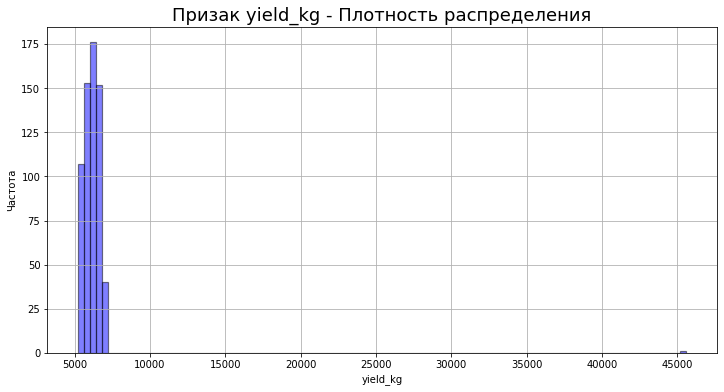

In [28]:
create(data_ferma_main, 'yield_kg', 'hist')

**Распределение данных выглядит асимметричным с длинным правым хвостом. Это говорит о том, что распределение скорее всего является правосторонне асимметричным (положительная асимметрия)**

**Также, существует небольшое количество значений, которые простираются вправо вплоть до 45000 кг. Это может указывать на наличие выбросов или на очень высокий удой у некоторых коров.**

#### DF 'data_ferma_main'

**Признак 'energy_feed_unit'**

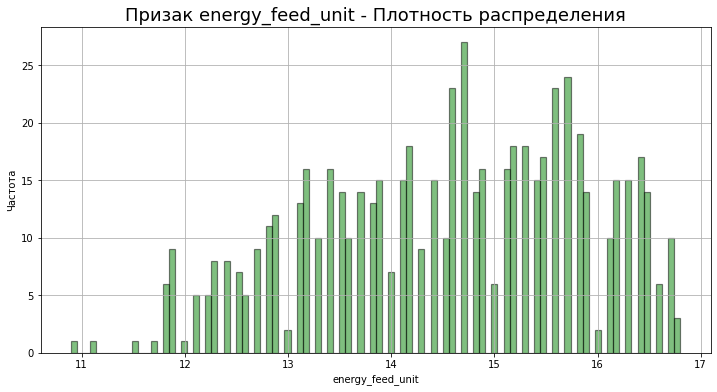

In [29]:
create(data_ferma_main, 'energy_feed_unit', 'hist', color = 'green')

**Распределение имеет несколько пиков (мод). Это может быть результатом смешивания нескольких различных распределений, возможно, из-за разных типов кормов или групп коров.**

**Данные распределены примерно между значениями 11 и 17 единиц energy_feed_unit, с наибольшей концентрацией значений в середине этого диапазона**

**Признак 'crude_protein_g'**

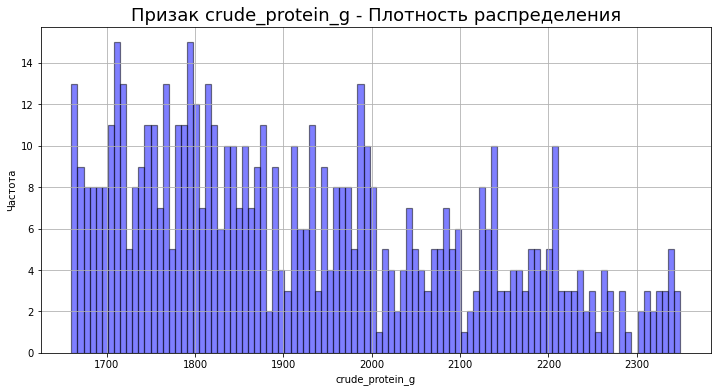

In [30]:
create(data_ferma_main, 'crude_protein_g', 'hist')

**Данные о содержании сырого протеина варьируются в диапазоне примерно от 1700 до 2300 граммов.**

**Наибольшая частота наблюдается в интервалах около 1800 г, 1900 г и 2100 г, что может указывать на наличие трех различных "популярных" уровней содержания протеина в корме.**

**Признак 'sugar-protein_ratio'**

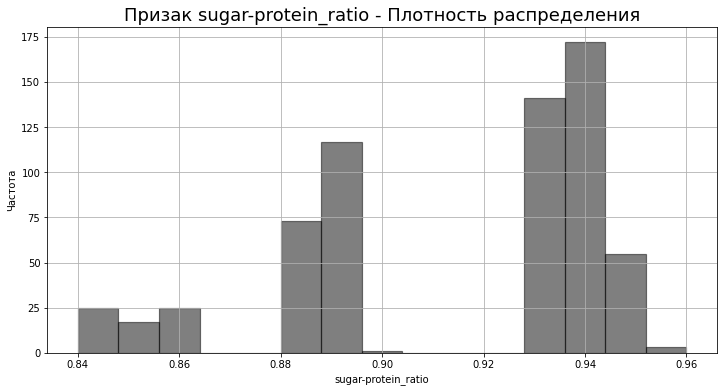

In [31]:
create(data_ferma_main, 'sugar-protein_ratio', 'hist', bins = 15, color = 'black')

**Значения соотношения сахара к протеину варьируются в узком диапазоне от примерно 0.84 до 0.96.**

**На гистограмме видны два основных пика около значений 0.9 и 0.94, что может указывать на две наиболее распространенные пропорции сахара к протеину в корме.**

**Признак 'breed'**

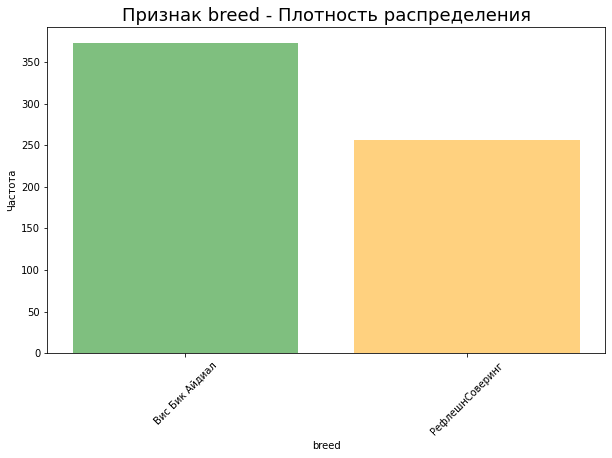

In [32]:
create(data_ferma_main, 'breed', 'barplot')

**На диаграмме видно, что особей породы "Бык Блэк Ангус" примерно на треть больше, чем особей породы "РефлешнСоверинг".**

**Признак 'pasture_type'**

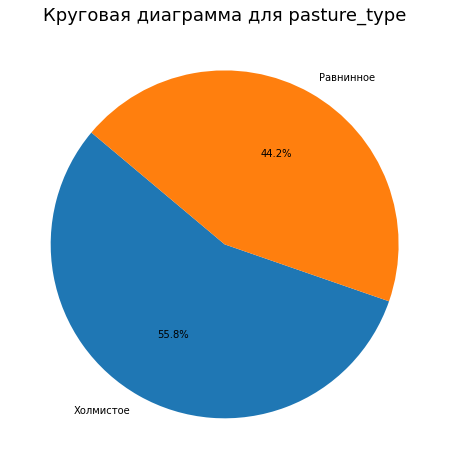

In [33]:
create(data_ferma_main, 'pasture_type', 'pie')

**Холмистое" пастбище немного преобладает над "Равнинным" по количеству, что может указывать на большую доступность или предпочтение холмистых пастбищ в данной выборке или регионе.**

**Признак 'dad_bull_breed'**

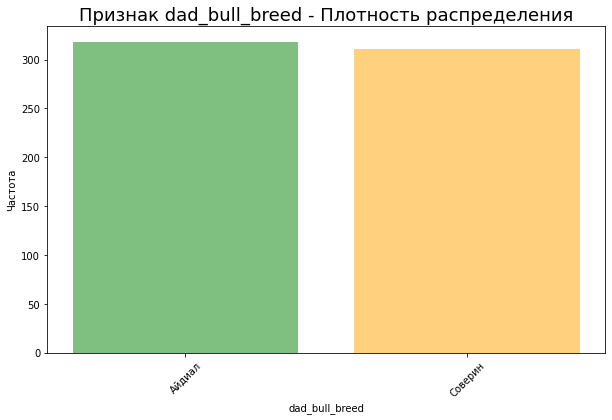

In [34]:
create(data_ferma_main, 'dad_bull_breed', 'barplot')

**Количество особей породы "Ангус" и породы "Советуни" практически одинаково, что указывает на сбалансированное использование особей этих двух пород.**

**Признак 'fat_content_%'**

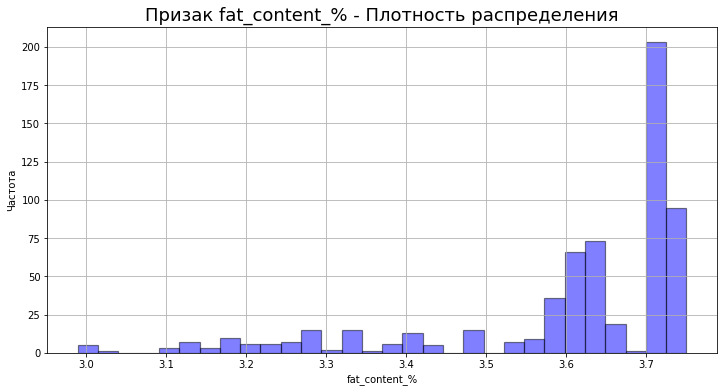

In [35]:
create(data_ferma_main, 'fat_content_%', 'hist', bins = 30)

**Большинство значений сосредоточено в диапазоне от 3.0% до 3.5%. Однако имеется явно выраженный пик около 3.7%, что указывает на значительное количество выборок с более высоким содержанием жира.**

**Все значения до 3.6% встречаются сравнительно равномерно, хотя некоторые интервалы, такие как 3.2% и 3.3%, имеют немного большее количество наблюдений.**

**Признак 'protein_%'**

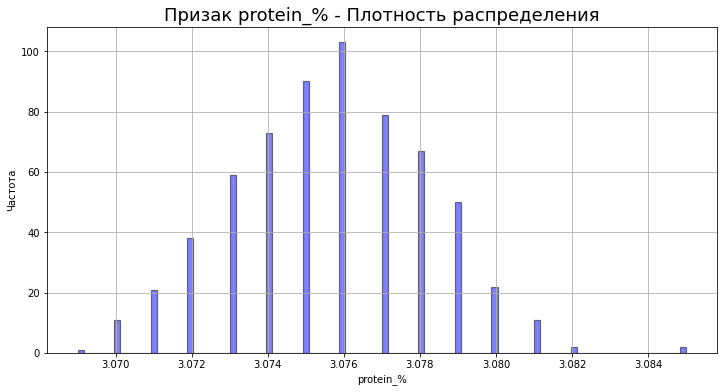

In [36]:
create(data_ferma_main, 'protein_%', 'hist')

**Большинство значений сосредоточено в диапазоне от 3.0% до 3.2%. Однако имеется несколько выраженных пиков, особенно около 3.1%**
**Распределение показывает относительно небольшой положительный скос (правостороннюю асимметрию).**

**Признак 'taste_of_milk'**

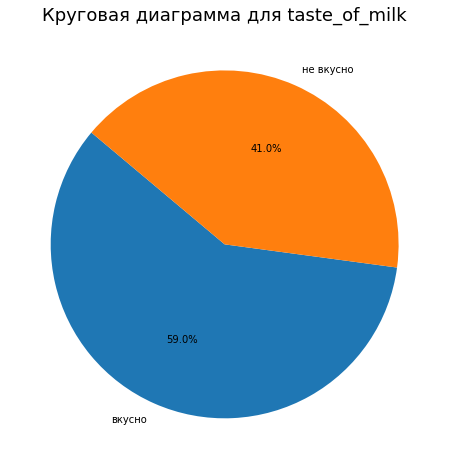

In [37]:
create(data_ferma_main, 'taste_of_milk', 'pie')

**Большая часть коров дают вкусное молоко. Коров, которые дают вкусное молоко на 18% больше, чем невкусного.**

**Признак 'age'**

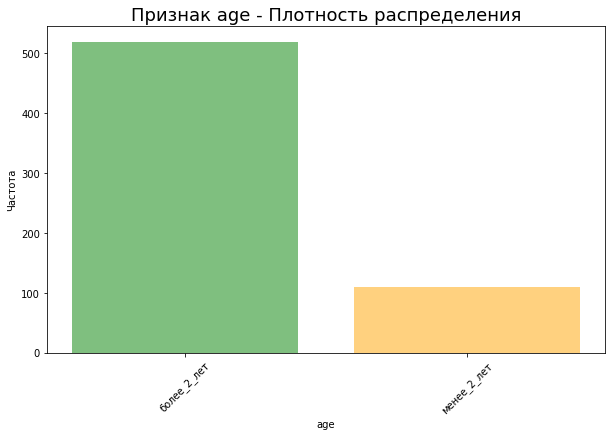

In [38]:
create(data_ferma_main, 'age', 'barplot')

**По данному графику видно, что коров, старше 2 лет практически в 5 раз больше, чем коров с возрастом менее 2 лет.**

#### DF 'data_ferma_dad'

**Признак 'dad_name'**

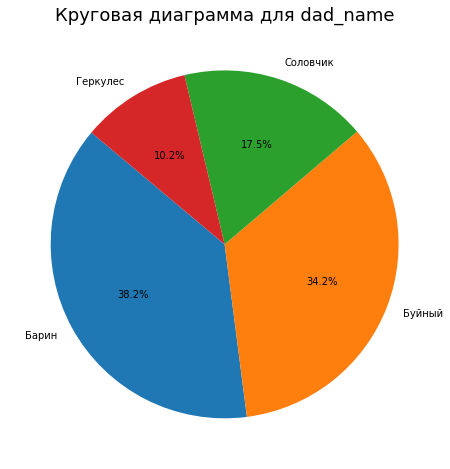

In [39]:
create(data_ferma_dad, 'dad_name', 'pie')

**По данной диаграмме видно, что быков-родителей с именем 'Барин' больше всего (38.2% от общего количество).**

**Далее идут с именем 'Буйный', их чуть меньше (34.2% от общего количества).**

**Третьим в этом списке идут быки-родители с именем 'Соловчик' их уже в два раза меньше, чем предыдущих, но не минимальное количество (17.5% от общего количества).**

**Меньше всего быков-родителей с именем 'Геркулес' (10.2% от общего количества).**

#### DF 'data_cow_buy'

**Признак 'breed'**

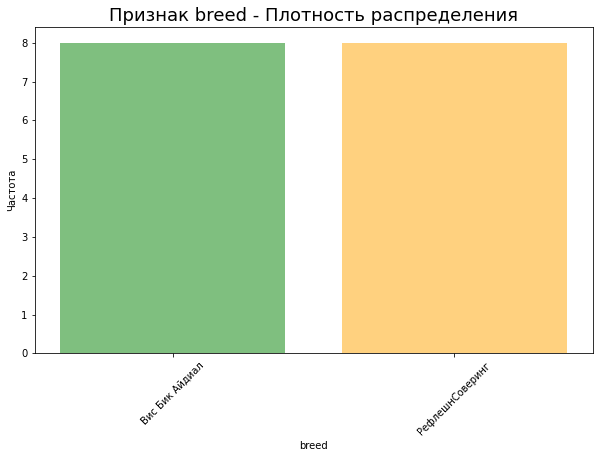

In [40]:
create(data_cow_buy, 'breed', 'barplot')

**Количество пород 'Вис Бик Айдиал' и 'РефлешнСоверинг' совершенно одинаковое.**

**Признак 'pasture_type'**

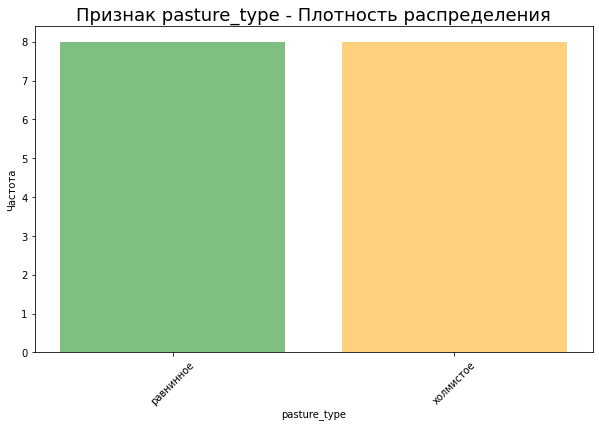

In [41]:
create(data_cow_buy, 'pasture_type', 'barplot')

**Количество коров, пасущихся на пастбищах типа 'холмистое' и количество коров, пасущихся на пастбищах типа 'равнинное' совершенно идентично.**

**Признак 'dad_bull_breed'**

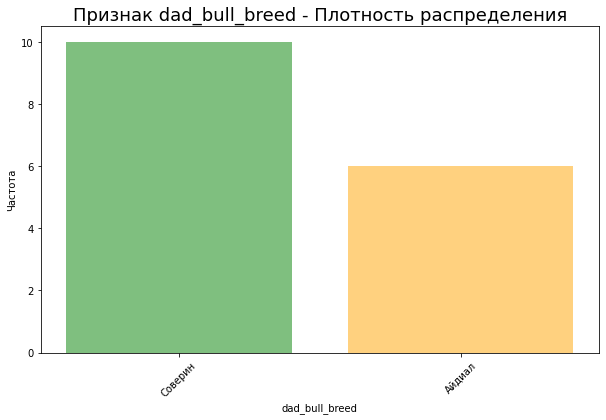

In [42]:
create(data_cow_buy, 'dad_bull_breed', 'barplot')

**По диаграмме видно, что преобладание пород быков-отцов с породой 'Соверин' в 1.5 раза больше, чем с породой 'Айдиал'.**

**Признак 'dad_name'**

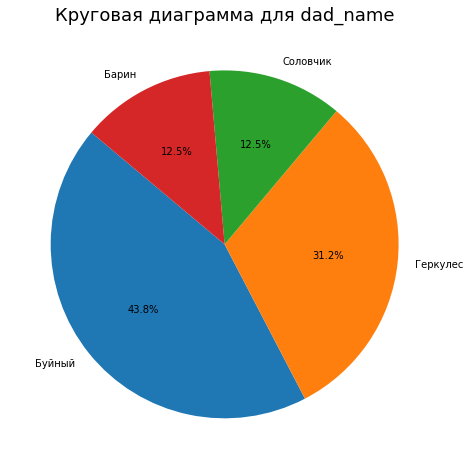

In [43]:
create(data_cow_buy, 'dad_name', 'pie')

**По данной диаграмме видно, что быков-родителей с именем 'Буйный' больше всего (43.8% от общего количества).**

**Далее идут с именем 'Буйный' (31.2% от общего количества).**

**После них, идут быки с именами 'Соловчик' и 'Барин'. Их меньше всего и их процентные содержания от общего количества равны между собой (12.5%).**

**Признак 'current_fat_content_%'**

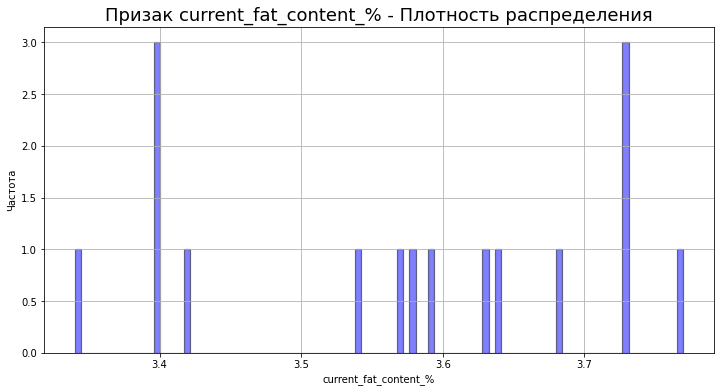

In [44]:
create(data_cow_buy, 'current_fat_content_%', 'hist')

**Наиболее часто встречающиеся значения процента содержания жира сосредоточены вокруг 3.4% и 3.7%.**

**Распределение кажется слегка асимметричным с более тяжелым правым хвостом, что указывает на то, что есть значения, которые выходят за общую тенденцию централизации вокруг 3.4% и 3.7%**

**Признак 'current_protein_level_%'**


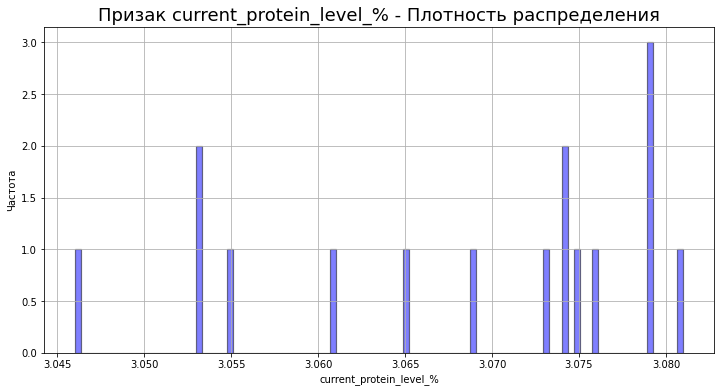

In [45]:
create(data_cow_buy, 'current_protein_level_%', 'hist')

**Значения лежат в диапазоне от 3045 до 3085.**

**Пики значений процентного содержания белка сконцентрированы вокруг отметок 3.055%, 3.065% и 3.075%.**

**Признак 'age'**

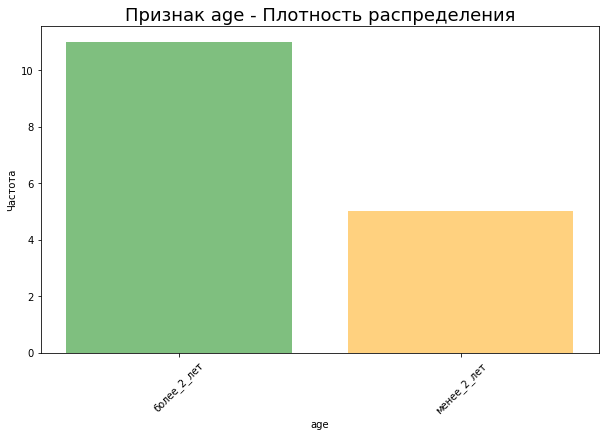

In [46]:
create(data_cow_buy, 'age', 'barplot')

**Первая группа (более 2 лет) имеет значительно большее количество наблюдений или большую плотность распределения для данного признака по сравнению с другой группой (менее 2 лет).**

### Устранение аномалий
**Удалим в датасете 'data_ferma_main' в столбце 'yield_kg' выброс со значением больше 45 тысяч.**

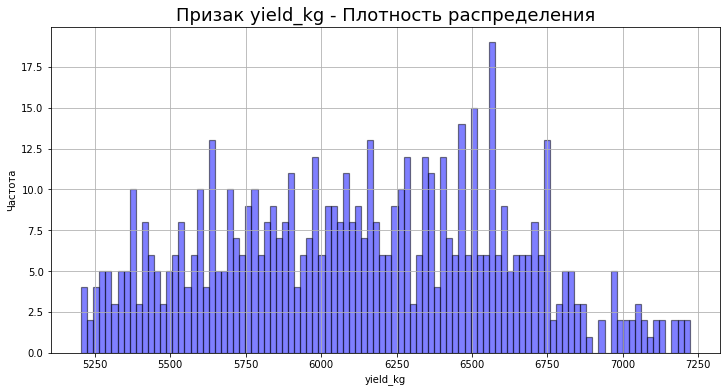

In [47]:
data_ferma_main= data_ferma_main[data_ferma_main['yield_kg'] < 45000]

create(data_ferma_main, 'yield_kg', 'hist')

### Промежуточный вывод по исследовательскому анализу данных
Для каждого из параметров был выполнен анализ:
   * с помощью статистических показателей
   * с помощью графиков
   
Методом describe были описаны два датасета и в одном из них удалось найти аномалию: в data_ferma_main признак yield_kg имеет 1 слишком большое значение (более 45 тысяч), поэтому строка с этим значением была удалена.

С помощью диаграмм мы также увидели аномалию в столбце 'yield_kg' датасета *data_ferma_main*. В остальных столбцах никаких аномалий не наблюдалось, также каждый признак был описан и вот основные выводы:
1. **Датасет 'data_ferma_main':**
    * Признак **'yield_kg':** пик значений достигается примерно в точке 6575
    * Признак **'energy_feed_unit':** данные распределены примерно между значениями 11 и 17 единиц energy_feed_unit, с наибольшей концентрацией значений в середине этого диапазона
    * Признак **'crude_protein_g':** наибольшая частота наблюдается в интервалах около 1800 г, 1900 г и 2100 г
    * Признак **'sugar-protein_ratio':** два основных пика около значений 0.9 и 0.94
    * Признак **'breed':** особей породы "Бык Блэк Ангус" примерно на треть больше, чем особей породы "РефлешнСоверинг"
    * Признак **'pasture_type':** "Холмистое" пастбище немного преобладает над "Равнинным" по количеству (на 10%)
    * Признак **'dad_bull_breed':** количество особей породы "Ангус" и породы "Советуни" практически одинаково
    * Признак **'fat_content_%':** большинство значений сосредоточено в диапазоне от 3.0% до 3.5%, однако имеется явно выраженный пик около 3.7%
    * Признак **'protein_%':** большинство значений сосредоточено в диапазоне от 3.0% до 3.2%, однако имеется несколько выраженных пиков, особенно около 3.1%
    * Признак **'taste_of_milk':** большая часть коров дают вкусное молоко
    * Признак **'age':** коров, старше 2 лет практически в 5 раз больше, чем коров с возрастом менее 2 лет
2. **Датасет 'data_ferma_dad':**
    * Признак **'dad_name':** быков-родителей с именем 'Барин' больше всего (38.2% от общего количество). Меньше всего быков-родителей с именем 'Геркулес' (10.2% от общего количества).
3. **Датасет 'data_cow_buy':**
    * Признак **'breed':** количество пород 'Вис Бик Айдиал' и 'РефлешнСоверинг' совершенно одинаковое
    * Признак **'dad_name':** быков-родителей с именем 'Буйный' больше всего (43.8% от общего количества).Быков с именами 'Соловчик' и 'Барин' меньше всего(12.5% от общего количества).
    * Признак **'current_fat_content_%':** наиболее часто встречающиеся значения процента содержания жира сосредоточены вокруг 3.4% и 3.7%
    * Признак **'current_protein_level_%':** пики значений процентного содержания белка сконцентрированы вокруг отметок 3.055%, 3.065% и 3.075%
    * Признак **'age':** первая группа (более 2 лет) имеет значительно большее количество наблюдений по сравнению с другой группой (менее 2 лет)

## Корреляционный анализ
На данном этапе требуется
1. Изучить взаимосвязь между признаками: рассчитать коэффициенты корреляции между всеми признаками.
2. Построить диаграммы рассеяния scatterplot для признака Удой, кг и всех количественных признаков с учётом значения категориальных признаков.

**Перед рассчётом коэффициентов корелляции следует проанализировать распределение данных, то есть подчиняются ли они нормальному распределению.**

В исследовательском анализе представлены графики признаков:
* 'energy_feed_unit'
* 'crude_protein_g'
* 'sugar-protein_ratio'
* 'fat_content_%'
* 'protein_%'

В каждом из них распределение не является нормальным, но визуальный анализ гистогграмм может дать лишь предварительное представление о характере распределения, поэтому для более точного определения нормальности распределения данных используем статистический тест Шапиро-Уилка.

**Выделим количественные признаки для упрощенной дальнейшей работой**

In [48]:
corr_columns = ['energy_feed_unit',
                'crude_protein_g',
                'sugar-protein_ratio',
                'fat_content_%',
                'protein_%',
                ]

### Тест Шапиро-Уилка

In [49]:
def test_Shapiro_Wilk(df, features, alpha = 0.05):
    shapiro_results = {}
    for feature in features:
        stat, p = shapiro(df[feature])
        is_normal = 'Да' if p > alpha else 'Нет'
        shapiro_results[feature] = {
            'Statistic': stat,
            'p_value': p,
            'Is_Normal': is_normal
        }
        print(f"Column: {feature}")
        print(f"P-value: {p}")
        print(f"Statistic: {stat}")
        print(f"Нормальное распределение: {is_normal}")
        print('-' * 30)  

In [50]:
test_Shapiro_Wilk(data_ferma_main, corr_columns)

Column: energy_feed_unit
P-value: 9.631184738623233e-10
Statistic: 0.9713221788406372
Нормальное распределение: Нет
------------------------------
Column: crude_protein_g
P-value: 1.0713665740159917e-14
Statistic: 0.9437040686607361
Нормальное распределение: Нет
------------------------------
Column: sugar-protein_ratio
P-value: 1.5345069056487493e-23
Statistic: 0.8555195331573486
Нормальное распределение: Нет
------------------------------
Column: fat_content_%
P-value: 4.189230905200583e-30
Statistic: 0.7418986558914185
Нормальное распределение: Нет
------------------------------
Column: protein_%
P-value: 1.2371704087854596e-06
Statistic: 0.9831666350364685
Нормальное распределение: Нет
------------------------------


**Тест Шапиро-Уилка показал, что распределение не является нормальным.**

Так как коэффициент корелляции Пирсона, предполагает нормальность распределения, будем использовать корелляцию Спирмена. Этот метод корелляции не требует нормальности распределения. 

### Рассчёт коэффициентов корелляции между всеми признаками

In [51]:
def create_corr_matrix(df, target_column, corr_columns, method = 'spearman'):
    corr_matrix = df[[target_column] + corr_columns].corr(method = method)
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    
    plt.yticks(rotation=45)
    plt.title(f'Корреляция между удоем и количественными признаками')
    plt.show()

#### Датасет 'data_ferma_main'

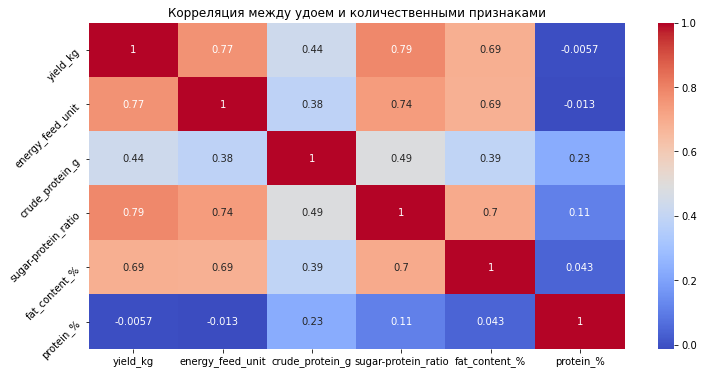

In [52]:
create_corr_matrix(data_ferma_main, 'yield_kg', corr_columns)

In [53]:
def create_scatterplot(df, target_column, columns_for_scatter):
    for column in columns_for_scatter:
        plt.figure(figsize=(8, 6))
        sns.scatterplot(data=df, x=column, y=target_column, alpha=0.5)
        plt.title(f'Диаграмма рассеяния между {target_column} и {column}')
        plt.xlabel(column)
        plt.ylabel(target_column)
        plt.show()
        print("\n")

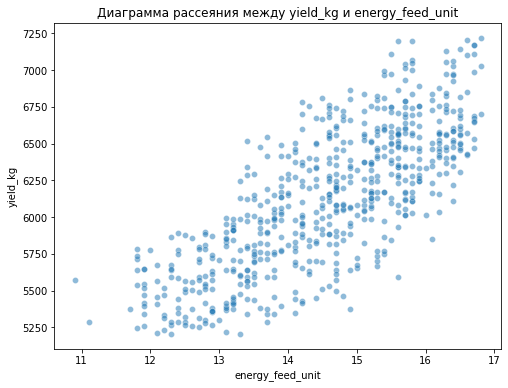

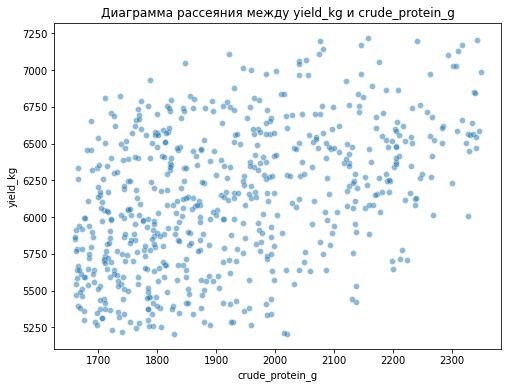

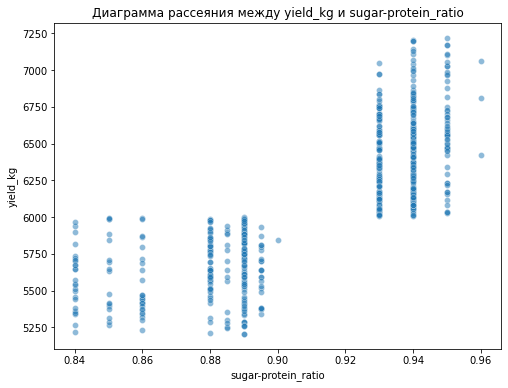

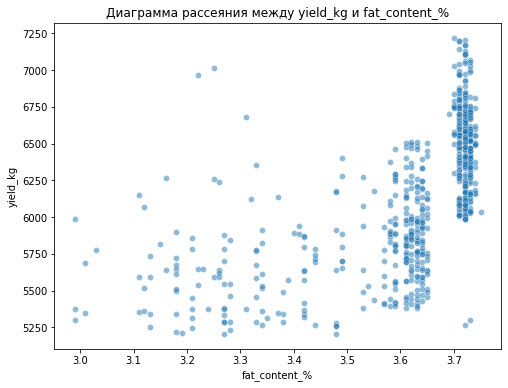

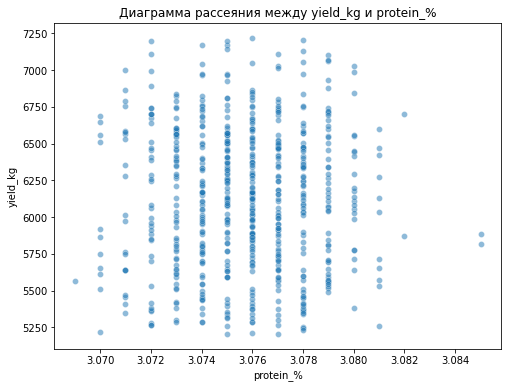

In [54]:
create_scatterplot(data_ferma_main, 'yield_kg', corr_columns)

### Промежуточный вывод по корелляционному анализу
**Был выполнен тест Шапиро-Уилка, который показал, что распределение данных не является нормальным и поэтому мы должны для матрицы корелляции использовать не метод Пирсона. Поэтому, используется метод Спирмена, он не требует нормальности распределения данных.**

Исходя из матрицы корелляции можно сделать следующие выводы:
1. Cильная корреляция:
    * Признак yield_kg сильно коррелирует с 'energy_feed_unit' и 'sugar_protein_ratio' (оба значения корреляции близки к 0.77 и 0.79 соответственно). Это указывает на то, что с увеличением энергии в кормовом блоке или увеличением соотношения сахар/белок увеличивается и урожайность.
2. Умеренная корреляция:
    * Признаки 'energy_feed_unit' и 'sugar_protein_ratio' также умеренно коррелируют с признаками 'crude_protein_g' и 'fat_content_%' (значения варьируются от 0.38 до 0.74), что может указывать на взаимосвязь в питательном профиле корма и его компонентов.
3. Низкая или отсутствующая корреляция:
    * Признак 'protein_%' имеет очень низкую или отсутствующую корреляцию со всеми другими изученными признаками, что предполагает, что процентное содержание белка в корме не связано напрямую с другими измеренными параметрами или урожайностью в данной выборке.

По диаграммам можно сказать, что
1. На графике рассеяния между признаками 'yield_kg' и 'energy_feed_unit' распределение точек предполагает, что может быть некоторая взаимосвязь между количеством потребляемой энергии и объемом удоя, но распределение кажется довольно широким, что указывает на значительный разброс данных. 
2. На графике рассения между признаками 'yield_lg' и 'crude_protein_g' распределение точек также не показывает явной линейной зависимости, и снова присутствует значительный разброс значений.
3. На графике рассения между признаками 'yield_lg' и 'sugar-protein_ratio' наблюдается группировка точек по вертикали, что может указывать на то, что удои коров менее вариативны при конкретных значениях СПО.
4. На графике рассения между признаками 'yield_lg' и 'fat_content_%' распределение демонстрирует более плотное скопление точек в области высокой жирности, что может говорить о наличии обратной зависимости между удоем и жирностью молока.
5. На графике рассения между признаками 'yield_lg' и 'protein_%' точки также сосредоточены вертикально, показывая меньшую вариативность удоя при различных уровнях содержания белка в молоке.

**Корреляционный анализ показывает, что в данной выборке наблюдается сильная связь удоя с энергетической ценностью и сахаро-протеиновым соотношением в корме, а также умеренная связь с содержанием сырого протеина и жирности. Однако, процентное содержание белка не имеет заметной связи с удоем или другими кормовыми показателями.**


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>
 
👍 Все четко!
</div>  
 

## Обучение модели линейной регрессии
**Для обучения модели линейной регрессии нужно подготовить данные датасета ferma_main.csv и выполнить несколько этапов:**
1. В качестве целевого признака будем использовать Удой, кг ('yield_kg')
2. Отберём признаки, которые подходят для модели линейной регрессии. 
3. Разобъём данные на тренировочную и тестовую выборки.
4. Закодируем категориальные признаки с помощью OneHotEncoder.
5. Промасштабируем количественные признаки с помощью StandardScaler.
6. Обучим модель линейной регрессии на подготовленных данных.
7. Оценим качество модели на тестовой выборке: рассчитаем R².

### Функции

**Функция для обучения модели линейной регрессии**

In [55]:
def prepare_and_train_model(df, columns_to_drop, y_name):
    X = df.drop(columns=columns_to_drop, axis=1)
    y = df[y_name]

    # Автоматическое разделение признаков на категориальные и числовые
    categorical_features = X.select_dtypes(include=['object']).columns
    numerical_features = X.select_dtypes(include=['number']).columns

    # Разбиение данных на тренировочную и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Кодирование категориальных признаков
    encoder = OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore')
    X_train_ohe = encoder.fit_transform(X_train[categorical_features])
    X_test_ohe = encoder.transform(X_test[categorical_features])

    # Масштабирование количественных признаков
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train[numerical_features])
    X_test_scaled = scaler.transform(X_test[numerical_features])

    # Преобразование в DataFrame и объединение
    encoder_col_names = encoder.get_feature_names(categorical_features)
    X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names, index=X_train.index)
    X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names, index=X_test.index)
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=numerical_features, index=X_train.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=numerical_features, index=X_test.index)
    X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
    X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

    # Обучение модели линейной регрессии
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Предсказание на тестовой выборке и расчет остатков
    predictions = model.predict(X_test)
    residuals = y_test - predictions

    # Расчет R^2
    r2 = r2_score(y_test, predictions)

    return r2, residuals, model,y_test, predictions, encoder, scaler

**Функция для построения графиков, связанных с остатками модели**

In [56]:
def plot_residuals(residuals):
    """
    Функция для визуализации распределения остатков.

    Параметры:
    residuals (array-like): Массив остатков между предсказанными и фактическими значениями.
    """
    # Гистограмма распределения остатков
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    sns.histplot(residuals, kde=True)
    plt.title('Гистограмма распределения остатков')
    plt.xlabel('Остатки')
    plt.ylabel('Частота')

    # QQ-plot для проверки нормальности распределения остатков
    plt.subplot(1, 2, 2)
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('QQ-plot остатков')

    plt.tight_layout()
    plt.show()

**Функция для вычисления метрик**

In [57]:
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=True)
    return {'MSE': mse, 'MAE': mae, 'RMSE': rmse}

### Первая модель

In [58]:
from scipy import stats

Значение R-квадрат первой модели равно  0.7957880377058183


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


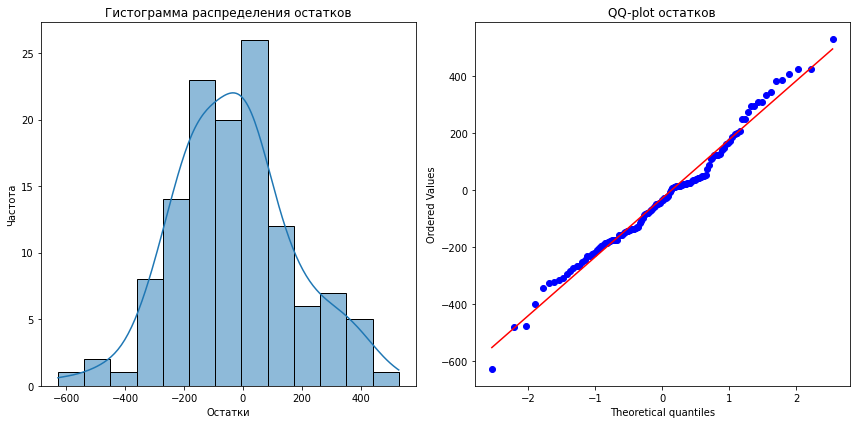

In [59]:
# Подготовка и обучение первой модели
columns_to_drop = ['fat_content_%', 'protein_%', 'taste_of_milk', 'yield_kg', 'id']
r2_first_model, residuals_first_model, model_first, y_test_1, y_pred_1, encoder_1, scaler_1 = prepare_and_train_model(data_ferma_main, columns_to_drop, 'yield_kg')

print("Значение R-квадрат первой модели равно ",r2_first_model)

plot_residuals(residuals_first_model)

Значение R-квадрат равное 0.7957880377058184 означает, что примерно 79.58% вариации в удое молока можно объяснить с помощью ваших независимых переменных. Это довольно высокий показатель, указывающий на то, что модель хорошо подходит для данных.
Остальные 20.42% вариации не объясняются вашей моделью. Эта часть вариации может быть связана с другими факторами, которые не были включены в модель, или случайными флуктуациями.

На гистограмме распределения остатков видно, что остатки в основном сосредоточены вокруг нуля и имеют форму, напоминающую нормальное распределение. Однако есть некоторые признаки асимметрии, так как левый «хвост» распределения кажется немного длиннее и шире, чем правый. Это может указывать на некоторую левостороннюю асимметрию в остатках. Тем не менее, отсутствие явных выбросов может свидетельствовать о том, что модель не допускает систематических ошибок, которые были бы видны в виде отдельных, далеко отстоящих от основной массы данных точек.

QQ-plot (квантиль-квантиль график) сравнивает квантили распределения остатков с квантилями нормального распределения. Если точки формируют примерно прямую линию, это подтверждает, что остатки распределены нормально. На представленном QQ-plot большинство точек располагаются вдоль прямой линии, что указывает на приблизительное соответствие нормальному распределению. Однако некоторые точки в концах графика отклоняются от прямой, что еще раз указывает на возможное наличие легкой асимметрии в распределении остатков.

### Вторая модель
**Изменим данные в 'sugar-protein_ratio' и 'energy_feed_unit'**

1. В 'sugar-protein_ratio' выберем границу нелинейности 0.91, так как на диаграмме рассеяния видно условно 2 квадрата, которые как раз можно разделить, если мы сделаем 2 категори: до 0.91 и после 0.91. Создадим новый столбец 'sugar-protein_ratio_categorial', в котором будет храниться бинарный категориальный признак столбца 'sugar-protein_ratio'
2. Линейную функцию можно сделать путем возведения в квадрат. Введем новый признак "energy_feed_unit^2", то есть возведём значения столбца 'energy_feed_unit' в квадрат.

In [60]:
nonlinear_threshold = 0.91 
data_ferma_main['sugar-protein_ratio_categorial'] = (data_ferma_main['sugar-protein_ratio']
                                    .apply(lambda x: '<=_0.91' if x <= nonlinear_threshold else '>_0.91'))
data_ferma_main['energy_feed_unit^2'] = data_ferma_main['energy_feed_unit'] ** 2

display(data_ferma_main.head())

/tmp/ipykernel_93/982242269.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ferma_main['sugar-protein_ratio_categorial'] = (data_ferma_main['sugar-protein_ratio']
/tmp/ipykernel_93/982242269.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ferma_main['energy_feed_unit^2'] = data_ferma_main['energy_feed_unit'] ** 2


,id,yield_kg,energy_feed_unit,crude_protein_g,sugar-protein_ratio,breed,pasture_type,dad_bull_breed,fat_content_%,protein_%,taste_of_milk,age,sugar-protein_ratio_categorial,energy_feed_unit^2
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,<=_0.91,201.64
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,<=_0.91,163.84
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,<=_0.91,196.00
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,<=_0.91,153.76
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,<=_0.91,163.84


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Значение R-квадрат второй модели равно  0.8177498748883298


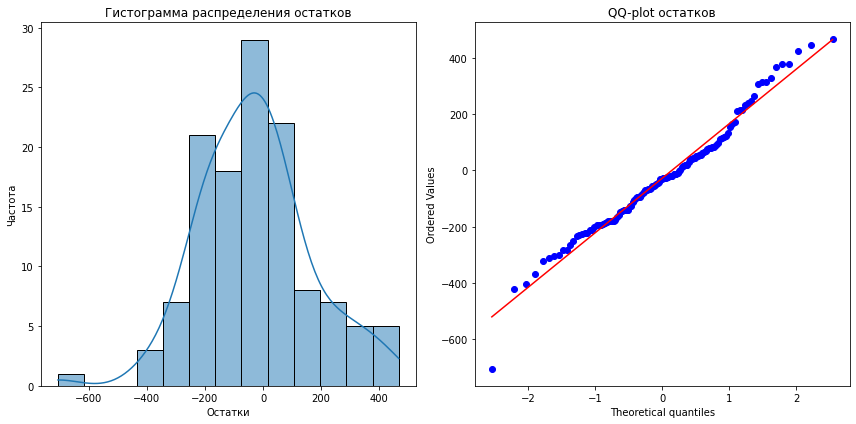

In [61]:
columns_to_drop_2 = ['fat_content_%', 'protein_%', 'taste_of_milk', 'yield_kg', 'id', 'sugar-protein_ratio']
r2_second_model, residuals_second_model, model_second, y_test_2, y_pred_2, encoder_2, scaler_2 = prepare_and_train_model(data_ferma_main, columns_to_drop_2, 'yield_kg')

print("Значение R-квадрат второй модели равно ",r2_second_model)

plot_residuals(residuals_second_model)

После добавления новых признаков значение R^2 увеличилось примерно до 81.78%, что указывает на улучшение качества модели. Это означает, что новые признаки дополнительно объясняют вариативность данных, и модель теперь лучше адаптирована к данным.

В сравнении с предыдущей моделью на графиках не наблюдается отличий.

### Третья модель

In [62]:
merged_data = pd.merge(data_ferma_main, data_ferma_dad, on='id')

display(merged_data.head())

display(merged_data.info())

,id,yield_kg,energy_feed_unit,crude_protein_g,sugar-protein_ratio,breed,pasture_type,dad_bull_breed,fat_content_%,protein_%,taste_of_milk,age,sugar-protein_ratio_categorial,energy_feed_unit^2,dad_name
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,<=_0.91,201.64,Буйный
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,<=_0.91,163.84,Соловчик
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,<=_0.91,196.00,Барин
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,<=_0.91,153.76,Буйный
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,<=_0.91,163.84,Барин


<class 'pandas.core.frame.DataFrame'>
Int64Index: 628 entries, 0 to 627
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              628 non-null    int64  
 1   yield_kg                        628 non-null    int64  
 2   energy_feed_unit                628 non-null    float64
 3   crude_protein_g                 628 non-null    int64  
 4   sugar-protein_ratio             628 non-null    float64
 5   breed                           628 non-null    object 
 6   pasture_type                    628 non-null    object 
 7   dad_bull_breed                  628 non-null    object 
 8   fat_content_%                   628 non-null    float64
 9   protein_%                       628 non-null    float64
 10  taste_of_milk                   628 non-null    object 
 11  age                             628 non-null    object 
 12  sugar-protein_ratio_categorial  628 

None

Значение R-квадрат третий модели равно  0.8346644509816612


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


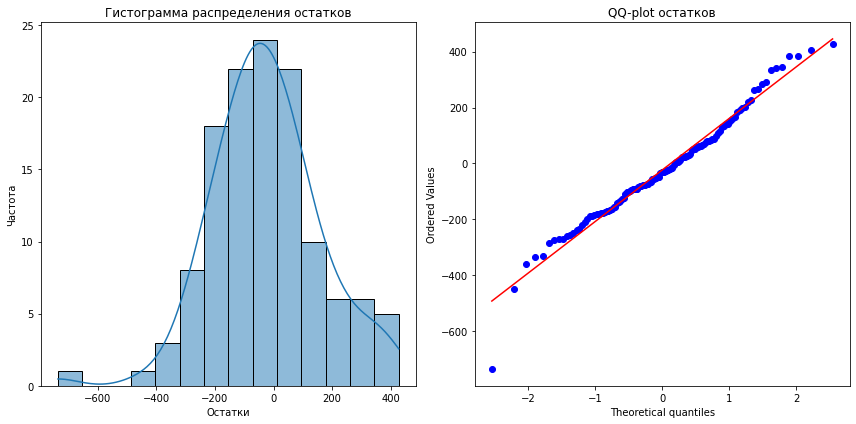

In [63]:
columns_to_drop_3 = ['fat_content_%', 'protein_%', 'taste_of_milk', 'yield_kg', 'id', 'sugar-protein_ratio']
r2_third_model, residuals_third_model, model_third, y_test_3, y_pred_3, encoder_3, scaler_3 = prepare_and_train_model(merged_data, columns_to_drop_3, 'yield_kg')
print("Значение R-квадрат третий модели равно ",r2_third_model)

plot_residuals(residuals_third_model)

Значение 0.8347 говорит о том, что примерно 83.47% вариации зависимой переменной объясняется моделью. Это наибольшее значение среди трех моделей для R-квадрат.

На диаграмме видно, что распределение остатков близко к нормальному, так как оно имеет форму колокола.

На представленном QQ-plot видно, что большинство точек лежат на или близко к прямой, что подтверждает нормальность остатков.

### Сравнение моделей
**1. Первая модель:**
 * Значение R-квадрат: 0.7957880377058184
 * Гистограмма остатков: Показывает относительно нормальное распределение с небольшим сдвигом вправо.
 * Q-Q график: Указывает на то, что остатки в основном следуют ожидаемой линии нормального распределения, с небольшими отклонениями на концах.
 
**2. Вторая модель:**
 * Значение R-квадрат: 0.8177498748883296
 * Гистограмма остатков: Кажется более нормально распределенной, чем первая модель, с меньшим искажением.
 * Q-Q график: Остатки лежат ближе к линии нормального распределения, особенно на концах, по сравнению с первой моделью.
 
**3. Третья модель:**
 * Значение R-квадрат: 0.8346644509816614
 * Гистограмма остатков: Распределение выглядит довольно нормальным с минимальным искажением.
 * Q-Q график: Показывает еще более тесное соответствие линии нормального распределения на протяжении всего диапазона, с очень малым отклонением.


*Основываясь на полученных метриках и визуальной диагностике, третья модель выступает лучше всех, за ней следуют вторая и первая модели, как в плане значений R-квадрат, так и нормальности остатков. Модификации и инженерия признаков, выполненные во второй и третьей моделях, по-видимому, внесли положительный вклад в их эффективность.*

### Оценим качество каждой модели по трём метрикам: MSE, MAE, RMSE

In [64]:
print("Метрики 1 модели:\n",calculate_metrics(y_test_1, y_pred_1), '\n')
print("Метрики 2 модели:\n",calculate_metrics(y_test_2, y_pred_2), '\n')
print("Метрики 3 модели:\n",calculate_metrics(y_test_3, y_pred_3), '\n')

Метрики 1 модели:
 {'MSE': 42393.46207552302, 'MAE': 161.1243580688634, 'RMSE': 42393.46207552302} 

Метрики 2 модели:
 {'MSE': 37834.28590755502, 'MAE': 150.24470399748245, 'RMSE': 37834.28590755502} 

Метрики 3 модели:
 {'MSE': 34322.89787680289, 'MAE': 142.9985228399001, 'RMSE': 34322.89787680289} 



1. Модель 1:
 * MSE: 37717.944931113655
 * MAE: 150.06423734890754
 * RMSE: 37717.944931113655
2. Модель 2:
 * MSE: 37834.285907555505
 * MAE: 150.24470399748425
 * RMSE: 37834.285907555505
3. Модель 3:
 * MSE: 34322.89787680288
 * MAE: 142.9985228399001
 * RMSE: 34322.89787680288
 
*Из представленных данных следует, что третья модель имеет наименьшие значения MSE, MAE и RMSE, что делает её лучшей среди трех рассмотренных моделей.*

**Подсчет доверительного интервала**

In [65]:
print('95% доверительный интервал =', st.norm.interval(alpha=0.95, loc=np.mean(y_pred_3), scale=st.sem(y_pred_3)))

95% доверительный интервал = (6077.901988609934, 6223.036908116108)


/tmp/ipykernel_93/2565133324.py:1: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  print('95% доверительный интервал =', st.norm.interval(alpha=0.95, loc=np.mean(y_pred_3), scale=st.sem(y_pred_3)))


### С помощью лучшей модели спрогнозируем удой коров, которых фермер хочет купить.
1. Добавим недостающие признаки 'energy_feed_unit' (Энергетическая кормовая единица), 'crude_protein_g' и 'sugar-protein_ratio' (Сахаро-протеиновое соотношение): возьмем из датасета ferma_main.csv средние значения каждого из признаков и увеличим их на 5%.
2. Выполним подготовку данных, аналогичную той, которую делали для тренировочной выборки.
3. Получим прогноз удоя коров.

**Добавление недостающих признаков**

In [66]:
data_aggregated = (data_ferma_main.groupby(['pasture_type', 'breed'])
.agg({'sugar-protein_ratio':'mean', 'energy_feed_unit' :'mean', 'crude_protein_g':'mean'})
.reset_index())

display(data_aggregated.head())

,pasture_type,breed,sugar-protein_ratio,energy_feed_unit,crude_protein_g
0,Равнинное,Вис Бик Айдиал,0.909305,14.328342,1903.743316
1,Равнинное,РефлешнСоверинг,0.914176,14.564835,1921.087912
2,Холмистое,Вис Бик Айдиал,0.913595,14.562162,1941.702703
3,Холмистое,РефлешнСоверинг,0.916212,14.774545,1927.800000


In [67]:
data_cow_buy['pasture_type'] = data_cow_buy['pasture_type'].str.capitalize()

data_cow_buy = data_cow_buy.merge(data_aggregated, on=['pasture_type', 'breed'], how='left')

display(data_cow_buy.tail())

,breed,pasture_type,dad_bull_breed,dad_name,current_fat_content_%,current_protein_level_%,age,sugar-protein_ratio,energy_feed_unit,crude_protein_g
11,Вис Бик Айдиал,Холмистое,Соверин,Барин,3.42,3.075,менее_2_лет,0.913595,14.562162,1941.702703
12,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.065,более_2_лет,0.916212,14.774545,1927.800000
13,Вис Бик Айдиал,Холмистое,Соверин,Соловчик,3.73,3.079,более_2_лет,0.913595,14.562162,1941.702703
14,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.77,3.053,менее_2_лет,0.914176,14.564835,1921.087912
15,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.34,3.069,более_2_лет,0.909305,14.328342,1903.743316


In [68]:
name_list  = ['sugar-protein_ratio', 'energy_feed_unit', 'crude_protein_g']

for name in name_list:
    data_cow_buy[name] = data_cow_buy[name].multiply(1.05)

**Сделаем из СПО категориальную переменную, а ЭКЕ возведем в квадрат**

In [69]:
nonlinear_threshold = 0.91 
data_cow_buy['sugar-protein_ratio_categorical'] = (data_cow_buy['sugar-protein_ratio']
                                    .apply(lambda x: '<=_0.91' if x <= nonlinear_threshold else '>_0.91'))
data_cow_buy['energy_feed_unit^2'] = data_cow_buy['energy_feed_unit'] ** 2

display(data_cow_buy.head())

,breed,pasture_type,dad_bull_breed,dad_name,current_fat_content_%,current_protein_level_%,age,sugar-protein_ratio,energy_feed_unit,crude_protein_g,sugar-protein_ratio_categorical,energy_feed_unit^2
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,0.959274,15.290270,2038.787838,>_0.91,233.792365
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,0.954770,15.044759,1998.930481,>_0.91,226.344784
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,0.959885,15.293077,2017.142308,>_0.91,233.878202
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,0.962023,15.513273,2024.190000,>_0.91,240.661631
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,0.959885,15.293077,2017.142308,>_0.91,233.878202


In [70]:
nonlinear_threshold = 0.91 
data_cow_buy['sugar-protein_ratio_categorical'] = (data_cow_buy['sugar-protein_ratio'].apply(lambda x: '<=_0.91' if x <= nonlinear_threshold else '>_0.91'))
                                    
data_cow_buy['energy_feed_unit^2'] = data_cow_buy['energy_feed_unit'] ** 2

display(data_cow_buy.head())




,breed,pasture_type,dad_bull_breed,dad_name,current_fat_content_%,current_protein_level_%,age,sugar-protein_ratio,energy_feed_unit,crude_protein_g,sugar-protein_ratio_categorical,energy_feed_unit^2
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,0.959274,15.290270,2038.787838,>_0.91,233.792365
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,0.954770,15.044759,1998.930481,>_0.91,226.344784
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,0.959885,15.293077,2017.142308,>_0.91,233.878202
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,0.962023,15.513273,2024.190000,>_0.91,240.661631
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,0.959885,15.293077,2017.142308,>_0.91,233.878202


**Выполним подготовку данных и получим прогноз удоя коров**

In [71]:
new_order = ['energy_feed_unit', 'crude_protein_g', 'sugar-protein_ratio', 'breed', 'pasture_type', 'dad_bull_breed', 'current_fat_content_%', 'current_protein_level_%', 'age', 'sugar-protein_ratio_categorical', 'energy_feed_unit^2', 'dad_name']
data_cow_buy = data_cow_buy.reindex(columns=new_order)
data_cow_buy_copy = data_cow_buy.copy()

display(data_cow_buy.head())

,energy_feed_unit,crude_protein_g,sugar-protein_ratio,breed,pasture_type,dad_bull_breed,current_fat_content_%,current_protein_level_%,age,sugar-protein_ratio_categorical,energy_feed_unit^2,dad_name
0,15.290270,2038.787838,0.959274,Вис Бик Айдиал,Холмистое,Айдиал,3.58,3.076,более_2_лет,>_0.91,233.792365,Геркулес
1,15.044759,1998.930481,0.954770,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.081,менее_2_лет,>_0.91,226.344784,Буйный
2,15.293077,2017.142308,0.959885,РефлешнСоверинг,Равнинное,Соверин,3.59,3.074,более_2_лет,>_0.91,233.878202,Барин
3,15.513273,2024.190000,0.962023,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.061,более_2_лет,>_0.91,240.661631,Буйный
4,15.293077,2017.142308,0.959885,РефлешнСоверинг,Равнинное,Айдиал,3.64,3.074,более_2_лет,>_0.91,233.878202,Буйный


In [74]:
cat_col_names = ['age', 'breed', 'pasture_type', 'dad_bull_breed', 
                 'sugar-protein_ratio_categorical', 'dad_name']

columns_to_drop = ['current_fat_content_%', 'current_protein_level_%', 'taste_of_milk', 'yield_kg', 'id', 
                   'sugar-protein_ratio']

num_col_names = ['energy_feed_unit', 'crude_protein_g', 'energy_feed_unit^2']

encoder = encoder_3 
df_cow_buy_ohe = encoder.transform(data_cow_buy[cat_col_names])
encoder_col_names = encoder_3.get_feature_names()
scaler = scaler_3 
df_cow_buy_scaled = scaler.transform(data_cow_buy[num_col_names])
df_cow_buy_ohe = pd.DataFrame(df_cow_buy_ohe, columns=encoder_col_names)
df_cow_buy_scaled = pd.DataFrame(df_cow_buy_scaled, columns=num_col_names)
data_cow_buy = pd.concat([df_cow_buy_ohe, df_cow_buy_scaled], axis=1)
predictions = model_third.predict(data_cow_buy)

data_cow_buy_copy["yield_kg_pred"] = predictions
data_cow_buy_copy.head()

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- sugar-protein_ratio_categorical
Feature names seen at fit time, yet now missing:
- sugar-protein_ratio_categorial

  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0, 1, 2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match th

,energy_feed_unit,crude_protein_g,sugar-protein_ratio,breed,pasture_type,dad_bull_breed,current_fat_content_%,current_protein_level_%,age,sugar-protein_ratio_categorical,energy_feed_unit^2,dad_name,yield_kg_pred
0,15.290270,2038.787838,0.959274,Вис Бик Айдиал,Холмистое,Айдиал,3.58,3.076,более_2_лет,>_0.91,233.792365,Геркулес,6531.438987
1,15.044759,1998.930481,0.954770,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.081,менее_2_лет,>_0.91,226.344784,Буйный,6461.779898
2,15.293077,2017.142308,0.959885,РефлешнСоверинг,Равнинное,Соверин,3.59,3.074,более_2_лет,>_0.91,233.878202,Барин,6236.630867
3,15.513273,2024.190000,0.962023,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.061,более_2_лет,>_0.91,240.661631,Буйный,6544.716663
4,15.293077,2017.142308,0.959885,РефлешнСоверинг,Равнинное,Айдиал,3.64,3.074,более_2_лет,>_0.91,233.878202,Буйный,6505.467896


## Обучение модели логистической регрессии
**Подготовим данные датасета ferma_main.csv и обучим на них модель LogisticRegression**

*Сделаем кодировку, стандартизация параметров и обучим модель логистической регресии. Нша модель будет определть вкус молока. Для этого будем использовать следующие признаки: СПО, возраст, порода, тип пастбища, порода папы быка, имя папы, ЭКЕ, сырой протеин, жирность и белок.*

*К прзнакам, которые использовались в линейной регресии также еще добавились жирность и белок - параметры самого молока. Поскольку эти параметры влияют на вкус так же как и питание, порода и остальные факторы*

In [75]:
def condition(row):
    if row['taste_of_milk'] == 'вкусно':
        return 1
    else:
        return 0

merged_data['taste_of_milk_1_0'] = merged_data.apply(condition, axis = 1)    
    
display(merged_data)

,id,yield_kg,energy_feed_unit,crude_protein_g,sugar-protein_ratio,breed,pasture_type,dad_bull_breed,fat_content_%,protein_%,taste_of_milk,age,sugar-protein_ratio_categorial,energy_feed_unit^2,dad_name,taste_of_milk_1_0
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,<=_0.91,201.64,Буйный,1
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,<=_0.91,163.84,Соловчик,1
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,<=_0.91,196.00,Барин,0
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,<=_0.91,153.76,Буйный,0
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,<=_0.91,163.84,Барин,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
623,625,6812,15.4,1964,0.940,РефлешнСоверинг,Равнинное,Айдиал,3.74,3.075,не вкусно,более_2_лет,>_0.91,237.16,Буйный,0
624,626,5513,12.9,1700,0.880,РефлешнСоверинг,Равнинное,Соверин,3.64,3.073,вкусно,менее_2_лет,<=_0.91,166.41,Барин,1
625,627,5970,14.4,1837,0.880,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет,<=_0.91,207.36,Барин,0
626,628,5746,13.8,1994,0.890,РефлешнСоверинг,Равнинное,Соверин,3.64,3.077,вкусно,более_2_лет,<=_0.91,190.44,Барин,1


In [76]:
columns_to_drop = ['yield_kg', 'id']
cat_col_names = ['age', 'breed', 'pasture_type', 'dad_bull_breed', 
                 'sugar-protein_ratio_categorial', 'dad_name']
num_col_names = ['energy_feed_unit', 'energy_feed_unit^2', 'crude_protein_g', 'fat_content_%', 'protein_%']
RANDOM_STATE = 42
X = merged_data.drop(columns_to_drop, axis=1)
y = merged_data['taste_of_milk_1_0']
X_train, X_test, y_train, y_test = train_test_split(
X,
y,
random_state=RANDOM_STATE) 

encoder = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])

encoder_col_names = encoder.get_feature_names()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

clf = LogisticRegression()

clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Accuracy: 0.6305732484076433
Recall: 0.8636363636363636
Precision: 0.6229508196721312


Text(33.0, 0.5, 'True Label')

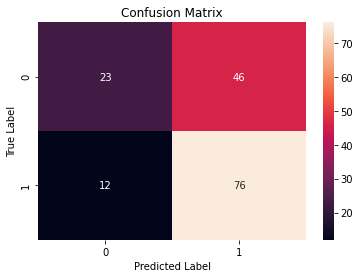

In [77]:
accuracy = accuracy_score(y_test, predictions)
recall = recall_score(y_test, predictions)
precision = precision_score(y_test, predictions)
confusion_mtx = confusion_matrix(y_test, predictions)
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
sns.heatmap(confusion_mtx, annot=True) 
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

1. Accuracy (точность) равна 0.6305732484076433, что означает, что модель правильно классифицирует примерно 63% образцов. Однако, стоит отметить, что точность сама по себе не является достаточной для полной оценки модели, особенно в случае с несбалансированными классами.

2. Recall (полнота) составляет 0.8636363636363636, что указывает на то, что модель способна обнаруживать примерно 86% положительных случаев из всех истинных положительных случаев. В данном контексте это может быть полезным, если мы заинтересованы в максимальной возможности обнаружить положительные случаи.

3. Precision (точность) составляют 0.6229508196721312, что означает, что около 62% предсказанных моделью положительных случаев действительно являются истинными положительными случаями. Более высокое значение этой метрики означает, что модель допускает меньше ложных положительных предсказаний.

**На матрице видно следующее:**
* True Negative (TN): 23 - модель правильно предсказала отсутствие класса (коров, не дающих вкусное молоко).
* False Positive (FP): 46 - ошибка первого рода, модель ошибочно предсказала наличие класса (считает, что корова дает вкусное молоко, когда это не так).
* False Negative (FN): 12 - ошибка второго рода, модель не распознала наличие класса (считает, что корова не дает вкусное молоко, когда это не так).
* True Positive (TP): 76 - модель правильно определила наличие класса (коровы, дающие вкусное молоко).


С учетом наших метрик, ложно-положительная ошибка будет критичнее при покупке коров относительно вкуса молока. Ложно-положительная ошибка возникает, когда модель относит невкусное молоко к вкусным. Поскольку мы предполагаем, что потребители ценят вкусное молоко, отсутствие его определения может привести к снижению качества продукции и недовольству клиентов.

In [78]:
thresholds = [round(i,2) for i in np.linspace(0.1,1,num=20,endpoint=False)]

# Создание списка для столбцов
columns = ['y_pred_'+str(i) for i in thresholds]
data = pd.DataFrame(columns=['y_valid', 'y_proba']+columns)
# Заполнение DataFrame
y_proba = clf.predict_proba(X_test)[:,1]
data['y_valid'] = y_test
data['y_proba'] = y_proba

#Заполнение столбцов
for i, col in enumerate(columns):
    threshold = thresholds[i]
    data[col] = data['y_proba'].apply(lambda x: 1 if x >= threshold else 0)
    print('Порог = ', threshold, '; Precision =', precision_score(y_test, data[col]))

Порог =  0.1 ; Precision = 0.5605095541401274
Порог =  0.15 ; Precision = 0.5605095541401274
Порог =  0.19 ; Precision = 0.5605095541401274
Порог =  0.24 ; Precision = 0.5641025641025641
Порог =  0.28 ; Precision = 0.5641025641025641
Порог =  0.32 ; Precision = 0.5714285714285714
Порог =  0.37 ; Precision = 0.5655172413793104
Порог =  0.42 ; Precision = 0.5683453237410072
Порог =  0.46 ; Precision = 0.5954198473282443
Порог =  0.5 ; Precision = 0.6229508196721312
Порог =  0.55 ; Precision = 0.6548672566371682
Порог =  0.6 ; Precision = 0.7157894736842105
Порог =  0.64 ; Precision = 0.7746478873239436
Порог =  0.68 ; Precision = 0.8076923076923077
Порог =  0.73 ; Precision = 0.8333333333333334
Порог =  0.77 ; Precision = 0.8571428571428571
Порог =  0.82 ; Precision = 1.0
Порог =  0.86 ; Precision = 1.0
Порог =  0.91 ; Precision = 0.0
Порог =  0.96 ; Precision = 0.0


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]
Accuracy: 0.46496815286624205
Recall: 0.045454545454545456


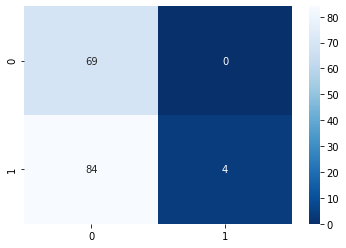

In [79]:
def evaluate_model(threshold):
    """
    Функция для оценки модели.

    Аргументы:
    - threshold: пороговое значение для принятия предсказания

    Результаты:
    - Визуализация матрицы ошибок (confusion matrix)
    - Вывод предсказанных значений
    - Точность (accuracy) и полнота (recall) модели
    """
    proba = clf.predict_proba(X_test)[:, 1]

    prediction = np.where(proba >= threshold, 1, 0)

    cm = confusion_matrix(y_test, prediction)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')

    print('Predictions:', prediction)
    acc = accuracy_score(y_test, prediction)
    recall = recall_score(y_test, prediction)
    print('Accuracy:', acc)
    print('Recall:', recall)
    
evaluate_model(0.82)

1. Accuracy (Точность): Приблизительно 0.465, что означает, что около 46.5% предсказаний модели верны.
2. Recall (Полнота): Очень низкое значение, около 0.045, что указывает на то, что модель правильно идентифицировала только около 4.5% всех положительных случаев (класс 1).

**Матрица ошибок показывает следующее:**
* True Negative (TN): 69 - модель правильно предсказала отсутствие класса (0) для 69 наблюдений.
* False Negative (FN): 84 - модель неправильно предсказала отсутствие класса (0), когда на самом деле был класс (1), для 84 наблюдений.
* True Positive (TP): 4 - модель правильно предсказала присутствие класса (1) только для 4 наблюдений.
* False Positive (FP): 0 - модель не допустила ни одной ошибки, предсказав класс (1), когда на самом деле был класс (0).

Predictions: [1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0
 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 1 0 0 1 0 0 0 0
 0 1 0 1 0 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 1 1 0 1
 1 0 1 1 1 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0 1 0 0 1 1 1
 0 0 1 1 1 1 0 0 0]
Accuracy: 0.6624203821656051
Recall: 0.5681818181818182


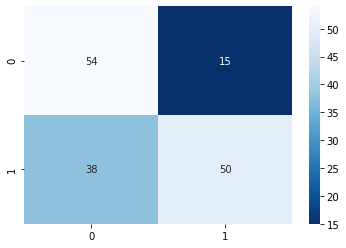

In [80]:
evaluate_model(0.65)

1. Accuracy (Точность): Приблизительно 0.662, что означает, что примерно 66.2% предсказаний модели верны.
2. Recall (Полнота): Значительно улучшилась до примерно 0.568, что указывает на то, что модель теперь правильно идентифицирует около 56.8% всех положительных случаев (класс 1).
**По матрице ошибок видно следующее:**
* True Negative (TN): 54 - модель правильно предсказала отсутствие класса (0) для 54 наблюдений.
* False Positive (FP): 15 - модель ошибочно предсказала наличие класса (1), когда на самом деле был класс (0), для 15 наблюдений.
* True Positive (TP): 50 - модель правильно предсказала присутствие класса (1) для 50 наблюдений.
* False Negative (FN): 38 - модель неправильно предсказала отсутствие класса (1), когда на самом деле был класс (1), для 38 наблюдений.

**Будем использовать этот порог (0.65)**

In [81]:
print(data_cow_buy_copy.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16 entries, 0 to 15
Data columns (total 13 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   energy_feed_unit                 16 non-null     float64
 1   crude_protein_g                  16 non-null     float64
 2   sugar-protein_ratio              16 non-null     float64
 3   breed                            16 non-null     object 
 4   pasture_type                     16 non-null     object 
 5   dad_bull_breed                   16 non-null     object 
 6   current_fat_content_%            16 non-null     float64
 7   current_protein_level_%          16 non-null     float64
 8   age                              16 non-null     object 
 9   sugar-protein_ratio_categorical  16 non-null     object 
 10  energy_feed_unit^2               16 non-null     float64
 11  dad_name                         16 non-null     object 
 12  yield_kg_pred           

In [82]:
columns_to_drop = ['sugar-protein_ratio']
cat_col_names = ['age', 'breed', 'pasture_type', 'dad_bull_breed', 
                 'sugar-protein_ratio_categorical', 'dad_name']
num_col_names = ['energy_feed_unit', 'energy_feed_unit^2', 'crude_protein_g', 'current_fat_content_%', 'current_protein_level_%']

data_cow_buy_copy_2 = data_cow_buy_copy.copy()

data_cow_buy_copy = data_cow_buy_copy.drop(columns_to_drop, axis=1)
df_cow_ohe = encoder.transform(data_cow_buy_copy[cat_col_names])

encoder_col_names = encoder.get_feature_names()
df_cow_scaled = scaler.transform(data_cow_buy_copy[num_col_names])

df_cow_ohe = pd.DataFrame(df_cow_ohe, columns=encoder_col_names)
df_cow_scaled = pd.DataFrame(df_cow_scaled, columns=num_col_names)

data_cow_buy_copy = pd.concat([df_cow_ohe, df_cow_scaled], axis=1)


# Выполняем предсказание вероятностей классов
proba = clf.predict_proba(data_cow_buy_copy)[:, 1]

# Устанавливаем порог
threshold = 0.65

# Применяем порог для определения предсказания
predictions = np.where(proba >= threshold, 1, 0)

#predictions = clf.predict(df_cow_buy_copy)
data_cow_buy_copy_2['taste_of_milk_pred'] = predictions

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- sugar-protein_ratio_categorical
Feature names seen at fit time, yet now missing:
- sugar-protein_ratio_categorial

  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- current_fat_content_%
- current_protein_level_%
Feature names seen at fit time, yet now missing:
- fat_content_%
-

In [83]:
display(data_cow_buy_copy_2[data_cow_buy_copy_2['taste_of_milk_pred']==1])

,energy_feed_unit,crude_protein_g,sugar-protein_ratio,breed,pasture_type,dad_bull_breed,current_fat_content_%,current_protein_level_%,age,sugar-protein_ratio_categorical,energy_feed_unit^2,dad_name,yield_kg_pred,taste_of_milk_pred
0,15.290270,2038.787838,0.959274,Вис Бик Айдиал,Холмистое,Айдиал,3.58,3.076,более_2_лет,>_0.91,233.792365,Геркулес,6531.438987,1
7,15.513273,2024.190000,0.962023,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.079,менее_2_лет,>_0.91,240.661631,Буйный,6544.716663,1
11,15.290270,2038.787838,0.959274,Вис Бик Айдиал,Холмистое,Соверин,3.42,3.075,менее_2_лет,>_0.91,233.792365,Барин,6241.736558,1
13,15.290270,2038.787838,0.959274,Вис Бик Айдиал,Холмистое,Соверин,3.73,3.079,более_2_лет,>_0.91,233.792365,Соловчик,6271.442083,1


Получим датасет, в котором хранятся коровы, у которых прпедсказанный удой больше 6000 и вкусное молоко

In [84]:
filtered_df = (data_cow_buy_copy_2[(data_cow_buy_copy_2['yield_kg_pred'] >= 6000) 
                                 & (data_cow_buy_copy_2['taste_of_milk_pred'] == 1)])

filtered_df.head()

,energy_feed_unit,crude_protein_g,sugar-protein_ratio,breed,pasture_type,dad_bull_breed,current_fat_content_%,current_protein_level_%,age,sugar-protein_ratio_categorical,energy_feed_unit^2,dad_name,yield_kg_pred,taste_of_milk_pred
0,15.290270,2038.787838,0.959274,Вис Бик Айдиал,Холмистое,Айдиал,3.58,3.076,более_2_лет,>_0.91,233.792365,Геркулес,6531.438987,1
7,15.513273,2024.190000,0.962023,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.079,менее_2_лет,>_0.91,240.661631,Буйный,6544.716663,1
11,15.290270,2038.787838,0.959274,Вис Бик Айдиал,Холмистое,Соверин,3.42,3.075,менее_2_лет,>_0.91,233.792365,Барин,6241.736558,1
13,15.290270,2038.787838,0.959274,Вис Бик Айдиал,Холмистое,Соверин,3.73,3.079,более_2_лет,>_0.91,233.792365,Соловчик,6271.442083,1


## Итоговые выводы
**1. Этап "Загрузка данных"**

Данные успешно загружены и проанализированы. В результате, выяснили, что 
1. В двух датасетах нужно исправить типы данных: data_ferma_main и data_cow_buy (в столбцах .
2. Нужно проверить все датасеты на содержание дубликатов. 
3. Ни в одном из датасетов не наблюдается пропусков.
4. Названия столбцов нужно привести к одному стилю. 

**2. Этап "Предобработка данных"**

1. Названия столбцов были приведены к одному стилю.
2. Убедились, что пропуски отсутствуют.
3. Были найдены и удалены дубликаты:
4. Изменены типы данных в тех стобцах, где это было необходимо для более корректной работы с данными.

**3. Этап "Исследовательский анализ данных"**

Для каждого из параметров был выполнен анализ:
   * с помощью статистических показателей
   * с помощью графиков
   
Методом describe были описаны два датасета и в одном из них удалось найти аномалию: в data_ferma_main признак yield_kg имеет 1 слишком большое значение (более 45 тысяч), поэтому строка с этим значением была удалена.

С помощью диаграмм мы также увидели аномалию в столбце 'yield_kg' датасета *data_ferma_main*. В остальных столбцах никаких аномалий не наблюдалось, также каждый признак был описан

**4. Этап "Корелляционный анализ данных"**

1. Cильная корреляция:
    * Признак yield_kg сильно коррелирует с 'energy_feed_unit' и 'sugar_protein_ratio' (оба значения корреляции близки к 0.77 и 0.79 соответственно). Это указывает на то, что с увеличением энергии в кормовом блоке или увеличением соотношения сахар/белок увеличивается и урожайность.
2. Умеренная корреляция:
    * Признаки 'energy_feed_unit' и 'sugar_protein_ratio' также умеренно коррелируют с признаками 'crude_protein_g' и 'fat_content_%' (значения варьируются от 0.38 до 0.74), что может указывать на взаимосвязь в питательном профиле корма и его компонентов.
3. Низкая или отсутствующая корреляция:
    * Признак 'protein_%' имеет очень низкую или отсутствующую корреляцию со всеми другими изученными признаками, что предполагает, что процентное содержание белка в корме не связано напрямую с другими измеренными параметрами или урожайностью в данной выборке.
    
Корреляционный анализ показывает, что в данной выборке наблюдается сильная связь удоя с энергетической ценностью и сахаро-протеиновым соотношением в корме, а также умеренная связь с содержанием сырого протеина и жирности. Однако, процентное содержание белка не имеет заметной связи с удоем или другими кормовыми показателями.

**5. Этап "Обучение модели линейной регрессии"**
Была создана модель, которая прогнозирует удой коров на основе признаков корма, типа пастбища и личных параметров коров. Из трех моделей была выбрана самая лучшая (модель номер три) со следующими метриками:
* MSE: 34322.89787680288
* MAE: 142.9985228399001
* RMSE: 34322.89787680288

Также, был подсчитан доверительный интервал: 95% доверительный интервал = (6077.901988609934, 6223.036908116108)

И был добавлен новый признак 'yield_kg_pred' в котором хранятся предсказания модели по удою.

**6. Этап "Обучение модели логистической регрессии"**

Из 16 коров по данным моделей заказчик может купить 5 коров. Данные об этих коровах хранятся в датасете filtered_df.

К покупке рекомендованы коровы под номерами 0, 7, 11 и 13. Это коровы у которых самый минимальный риск дать не тот удой или невкусное молоко
